# Use Case 7: Phrase Function Ambiguity (N1904addons)

## Table of content (ToC)<a class="anchor" id="TOC"></a>
* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Load N1904-TF with the N1904addons</a>
* <a href="#bullet3">3 - Performing the analysis</a>
    * <a href="#bullet3x1">3.1 - Phrase function variation in a Syntax Tree display</a>
    * <a href="#bullet3x2">3.2 - Distribution alternative tag sequence length</a>
* <a href="#bullet4">4 - Attribution and footnotes</a>
* <a href="#bullet5">5 - Required libraries</a>
* <a href="#bullet6">6 - Notebook version</a>


#  1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

This Jupyter Notebook explores an additional layer of analysis by not only identifying alternative morphological interpretations but also examining their potential syntactic impact; particularly in cases of phrase function ambiguity, a key form of syntactic ambiguity.

This can be implemented programmatically by using a feature that assigns statistical probabilities to specific morphological tags based on their observed occurrence within particular phrase roles.

It’s important to note that these probabilities are derived solely from patterns found in the full N1904 TF dataset. While each accepted alternative analysis theoretically shifts the statistical distribution, the overall impact remains marginal.

# 2 -  Load N1904-TF with the N1904addons <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

For this use case we do need both the base N1904-TF dataset with the Morpheus based extention N1904addons.

In [1]:
# Load the autoreload extension to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

In [2]:
# Loading the Text-Fabric code
from tf.fabric import Fabric
from tf.app import use

In [3]:
# Load the N1904-TF app and data with the additional features
A = use ("CenterBLC/N1904", mod=["tonyjurg/N1904addons/tf/", "tonyjurg/N1904addons/detailed_set"], silence="terse", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

In [4]:
# The following will push the Text-Fabric stylesheet to this notebook (to facilitate proper display with notebook viewer)
A.dh(A.getCss())

# 3 - Performing the analysis <a class="anchor" id="bullet3"></a>
##### [Back to ToC](#TOC)

## 3.1 - Phrase function variation in a Syntax Tree display <a class="anchor" id="bullet3x1"></a>

We begin by introducing the relevant Text-Fabric phrase feature set `ma{ind}_pf_altern`. For each phrase and each alternative morphological tag sequence, this feature encodes a probability distribution over possible phrase functions. These probabilities are based entirely on observed co-occurrence patterns in the full N1904 TF dataset.

Each feature value is a string that combines (1) the morphological tag sequence and (2) its associated phrase function probabilities. For example:

> ma1_pf_altern = T-ASM+N-ASM+P-GSM=o:88/s:12

Here, the index `1` refers to the first alternative tag sequence (`T-ASM+N-ASM+P-GSM`), which functions as an object in 88% of occurrences and as a subject in 12%.

The feature `ma0_pf_altern` is assigned to every phrase node and encodes the original tag sequence from the base N1904 TF dataset. It serves as the baseline for comparison with alternative analyses.

Now let us see the feature in action:

In [5]:
number_of_ma_sets=13 # Python range(start, stop) is start-inclusive, stop-exclusive.
featureList = (
    ['lemma','morph']
    + [f'ma{i}_pf_altern'  for i in range(0, number_of_ma_sets)]
)


In [6]:
A.show(A.search('phrase ma2_pf_altern num_words>2 ma1_pf_flip>40'),hiddenTypes={'subphrase','wg','group'}, end=1, extraFeatures=featureList,queryFeatures=False)

  0.06s 40 results


## 3.2 - Distribution alternative tag sequence length <a class="anchor" id="bullet3x2"></a>

The following script aggregates all `ma{ind}_pf_altern` feature occurences across the entire set of phrase nodes. The results are visualized in a stacked bar chart, where each bar represents a specific number of alternative morphological tag sequences assigned to a phrase. Within each bar, phrases are further subdivided by their length (only taking phrases up to ten words into account). The total number of phrases in each category is annotated above each bar, allowing for easy comparison of both variation and phrase length distribution.

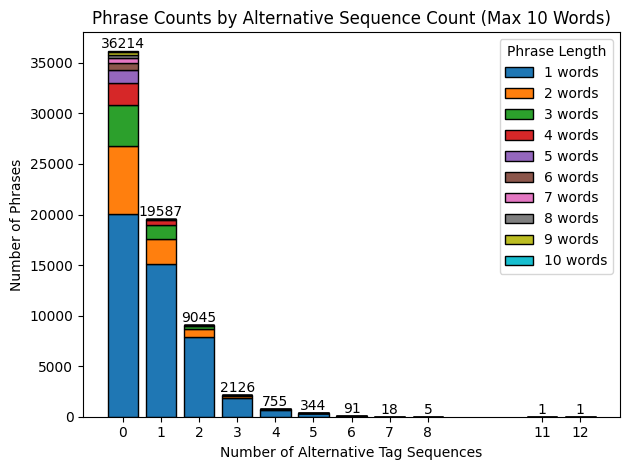

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# 1. Define the range of alternative-tag-combination features to check
#    BLOCK_RANGE represents all possible indices of the ma{n}_pf_altern features
BLOCK_RANGE = range(0, 13)
#    Map each block index to its corresponding Text-Fabric feature object
pf_feats = {n: Fs(f"ma{n}_pf_altern") for n in BLOCK_RANGE}

# 2. Count the number of alternative sequences per phrase,
#    excluding any phrase longer than 10 words
count_map = Counter()
for phrase in F.otype.s("phrase"):
    # 2.1 Retrieve the phrase length (number of word slots)
    length = F.num_words.v(phrase)
    # 2.2 Skip processing if phrase is longer than the specified threshold
    if length > 10:
        continue
    # 2.3 Determine the highest block index that has a valid feature value
    highest = 0
    for block in BLOCK_RANGE:
        raw = pf_feats[block].v(phrase)
        # 2.4 Check if the feature exists and contains a valid "=" to indicate data
        if raw and "=" in raw:
            highest = block
        else:
            # 2.5 Stop scanning further blocks once an index has no data
            break
    # 2.6 Increment count for the combination of (highest alt sequences, phrase length)
    count_map[(highest, length)] += 1

# 3. Prepare data for plotting
#    Extract sorted unique values of alternative-sequence counts and phrase lengths
alt_counts     = sorted({alt for alt, _ in count_map})
phrase_lengths = sorted({length for _, length in count_map})

# 3.1 Build a matrix where each row corresponds to an alt_count and each column
#     corresponds to a phrase_length; values are the number of phrases in that cell
matrix = [
    [count_map.get((alt, length), 0) for length in phrase_lengths]
    for alt in alt_counts
]

# 4. Plot a stacked bar chart
plt.figure()
# 4.1 Initialize a list of zeros to track the bottom position for stacking
bottom = [0] * len(alt_counts)
# 4.2 For each phrase length, plot a segment stacked on previous segments
for idx, length in enumerate(phrase_lengths):
    # Extract the counts for this phrase length across all alt_counts
    values = [row[idx] for row in matrix]
    plt.bar(
        alt_counts,             # x-axis categories: number of alternative sequences
        values,                 # heights: counts for this phrase length
        bottom=bottom,          # starting height for stacking
        label=f"{length} words",
        edgecolor="black"
    )
    # 4.3 Update bottom so the next bar segment stacks on top of the current one
    bottom = [bottom[i] + values[i] for i in range(len(bottom))]

# 5. Put also the totals above each stack
for i, alt in enumerate(alt_counts):
    total = sum(matrix[i])
    plt.text(alt, total + 1, str(total), ha='center', va='bottom')
    
# 6. Final plot adjustments
plt.xlabel("Number of Alternative Tag Sequences")
plt.ylabel("Number of Phrases")
plt.title("Phrase Counts by Alternative Sequence Count (Max 10 Words)")
plt.legend(title="Phrase Length")
plt.xticks(alt_counts)      # Show all alt_count categories on the x-axis
plt.tight_layout()          # Adjust layout to prevent clipping
plt.show()


# 4 - Attribution and footnotes <a class="anchor" id="bullet4"></a>
##### [Back to ToC](#TOC)

Greek base text: Nestle1904 Greek New Testament, edited by Eberhard Nestle, published in 1904 by the British and Foreign Bible Society. Transcription by [Diego Santos](https://sites.google.com/site/nestle1904/home). Public domain.

The [N1904-TF dataset](https://centerblc.github.io/N1904/) is available under the [MIT licence](https://github.com/CenterBLC/N1904/blob/main/LICENSE.md). Formal reference: 
> Tony Jurg, Saulo de Oliveira Cantanhêde, & Oliver Glanz. (2024). *CenterBLC/N1904: Nestle 1904 Text-Fabric data*. Zenodo. DOI: [10.5281/zenodo.13117911](https://doi.org/10.5281/zenodo.13117910).

The N1904addons Text-Fabric dataset is published at [tonyjurg.github.io/N1904addons/use_cases](https://tonyjurg.github.io/N1904addons/use_cases) and made available under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://github.com/tonyjurg/N1904addons/blob/main/LICENSE.md) license.

This Jupyter notebook is released under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://github.com/tonyjurg/N1904addons/blob/main/LICENSE.md).

# 5 - Required libraries<a class="anchor" id="bullet5"></a>
##### [Back to ToC](#TOC)

Since the scripts in this notebook utilize Text-Fabric, [it requires currently (Apr 2025) Python >=3.9.0](https://pypi.org/project/text-fabric) together with the following libraries installed in the environment:

    collections
    mathplot    
    
You can install any missing library from within Jupyter Notebook using either`pip` or `pip3`.

# 6 - Notebook version<a class="anchor" id="bullet6"></a>
##### [Back to ToC](#TOC)

<div style="float: left;">
  <table>
    <tr>
      <td><strong>Author</strong></td>
      <td>Tony Jurg</td>
    </tr>
    <tr>
      <td><strong>Version</strong></td>
      <td>1.3</td>
    </tr>
    <tr>
      <td><strong>Date</strong></td>
      <td>July 23, 2025</td>
    </tr>
  </table>
</div>